# InceptionV3 Model (Roboflow Dataset)

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import imutils
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

### Define constants

In [2]:
TRAIN_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training"
TEST_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Testing"
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
NUM_EPOCHS = 50

### Count of images Before filtering

In [3]:
print("Before filtering out images:")
for label in labels:
    train_count = len(os.listdir(os.path.join(TRAIN_PATH, label)))
    test_count = len(os.listdir(os.path.join(TEST_PATH, label)))
    print(f"{label}: Train - {train_count}, Test - {test_count}")
    
total_train_count = sum([len(os.listdir(os.path.join(TRAIN_PATH, label))) for label in labels])
total_test_count = sum([len(os.listdir(os.path.join(TEST_PATH, label))) for label in labels])
print(f"Total: Train - {total_train_count}, Test - {total_test_count}")

Before filtering out images:
glioma_tumor: Train - 1321, Test - 299
meningioma_tumor: Train - 1333, Test - 301
no_tumor: Train - 1406, Test - 381
pituitary_tumor: Train - 1445, Test - 300
Total: Train - 5505, Test - 1281


### Filtering images

In [4]:
# Initialize a dictionary to store the count of detected black images for each label
detected_count = {label: 0 for label in labels}

# Loop through each label folder in training and testing paths
for path in [TRAIN_PATH, TEST_PATH]:
    for label in labels:
        dir_path = os.path.join(path, label)

        # Loop through each image in the folder
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            img = cv2.imread(img_path)

            # Check if the image is mostly black
            if (img.max() <= 120):
                detected_count[label] += 1
                print(f"Detected {img_path} as mostly black. Maximum pixel value: {img.max()}")

                # Remove the detected black image from the original location
                os.remove(img_path)

# Print the count of detected black images for each label
for label in labels:
    print(f"Detected {detected_count[label]} mostly black images for {label} label.") 

if sum(detected_count.values()) == 0:
    print("No black images detected.")

Detected /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training/glioma_tumor/Tr-gl_0098_jpg.rf.012af3c23dfa4ba6ac684b6ca1c6ecc1.jpg as mostly black. Maximum pixel value: 104
Detected /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training/glioma_tumor/Tr-gl_0278_jpg.rf.afba7c9b4c8d5544baaf52e5fff2a7e1.jpg as mostly black. Maximum pixel value: 80
Detected /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training/glioma_tumor/Tr-gl_0325_jpg.rf.d15b26e5ef42c27e13cf82b9ab11b6f1.jpg as mostly black. Maximum pixel value: 110
Detected /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training/glioma_tumor/Tr-gl_0242_jpg.rf.87a059d797dea6a9b2cb57e84f9c4896.jpg as mostly black. Maximum pixel value: 70
Detected /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training/glioma_tumor/Tr-gl_0500_jpg.rf.2282d48313e15fe677fcb24cb3c0cfaa.jpg as mostly black. Maximum pixel value: 93
Detected

### Count of images After filtering

In [5]:
print("After filtering out images:")
for label in labels:
    train_count = len(os.listdir(os.path.join(TRAIN_PATH, label)))
    test_count = len(os.listdir(os.path.join(TEST_PATH, label)))
    print(f"{label}: Train - {train_count}, Test - {test_count}")
    
total_train_count = sum([len(os.listdir(os.path.join(TRAIN_PATH, label))) for label in labels])
total_test_count = sum([len(os.listdir(os.path.join(TEST_PATH, label))) for label in labels])
print(f"Total: Train - {total_train_count}, Test - {total_test_count}")

After filtering out images:
glioma_tumor: Train - 1164, Test - 299
meningioma_tumor: Train - 1178, Test - 301
no_tumor: Train - 1285, Test - 381
pituitary_tumor: Train - 1297, Test - 300
Total: Train - 4924, Test - 1281


### Show sample image of each labels

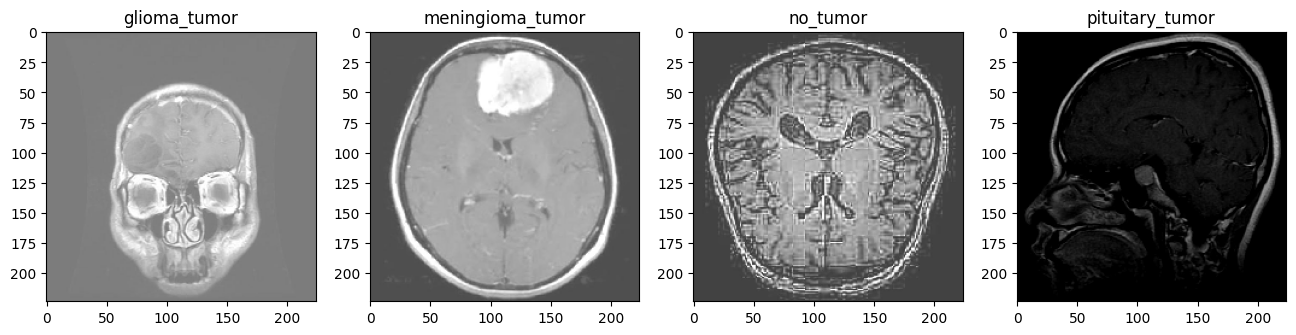

In [6]:
# Loop through the labels and show 1 sample from each folder horizontally
fig, axs = plt.subplots(1, len(labels), figsize=(16, 5))
for i, label in enumerate(labels):
  axs[i].set_title(label)

  # Get a list of images in the current folder
  directory = os.path.join(TRAIN_PATH, label)
  files = os.listdir(directory)

  # Show 1 sample image from the folder
  file = files[0]
  path = os.path.join(directory, file)
  img = tf.keras.preprocessing.image.load_img(path, target_size=IMAGE_SIZE)
  axs[i].imshow(img)
  
plt.show()

### Create data generators for training and validation with advanced data augmentation

In [7]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3941 images belonging to 4 classes.
Found 983 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


### Load the pre-trained InceptionV3 model without top layers

In [8]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 5s 0us/step


### Add new fully connected layers on top of the base model

In [9]:
x = Flatten()(base_model.output)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

### Create the model

In [10]:
model = Model(inputs=base_model.input, outputs=predictions)

### Freeze the pre-trained layers in the base model and train only the new layers

In [11]:
for layer in base_model.layers:
    layer.trainable = False

### Model Summary

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Visualize the model architecture

In [13]:
plot_model(model=model, show_shapes=True)

### Compile the model with categorical cross-entropy loss and a lower learning rate

In [14]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

### Save the Model

In [15]:
# Define a callback to save the best model weights
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/InceptionV3_RF_Final.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True, 
                              mode='max', 
                              verbose=1)

# Define a callback to track and print total training time and highest accuracy
class TimingCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.start_time = None
        self.total_time = 0.0
        self.highest_train_acc = 0.0
        self.highest_val_acc = 0.0
        self.highest_train_epoch = 0
        self.highest_val_epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.total_time += epoch_time
        print(f'Total training time for epoch {epoch + 1}: {epoch_time:.2f} seconds')

        train_acc = logs['accuracy']
        val_acc = logs['val_accuracy']

        if train_acc > self.highest_train_acc:
            self.highest_train_acc = train_acc
            self.highest_train_epoch = epoch + 1
        
        if val_acc > self.highest_val_acc:
            self.highest_val_acc = val_acc
            self.highest_val_epoch = epoch + 1

        print(f'Highest training accuracy: {self.highest_train_acc:.4f} at epoch {self.highest_train_epoch}')
        print(f'Highest validation accuracy: {self.highest_val_acc:.4f} at epoch {self.highest_val_epoch}')

### Train the model on training data and evaluate on validation data

In [16]:
timing_callback = TimingCallback()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint, timing_callback]
)

print(f'Total training time for {len(history.epoch)} epochs: {timing_callback.total_time:.2f} seconds')

Epoch 1/50
124/124 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.7359
Epoch 1: val_accuracy improved from -inf to 0.69379, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/InceptionV3_RF_Final.h5
Total training time for epoch 1: 108.83 seconds
Highest training accuracy: 0.7359 at epoch 1
Highest validation accuracy: 0.6938 at epoch 1
124/124 [==============================] - 109s 775ms/step - loss: 0.6735 - accuracy: 0.7359 - val_loss: 0.8147 - val_accuracy: 0.6938
Epoch 2/50
124/124 [==============================] - ETA: 0s - loss: 0.4164 - accuracy: 0.8470
Epoch 2: val_accuracy improved from 0.69379 to 0.75076, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/InceptionV3_RF_Final.h5
Total training time for epoch 2: 94.59 seconds
Highest training accuracy: 0.8470 at epoch 2
Highest validation accuracy: 0.7508 at epoch 2
124/124 [==============================] - 95s 764ms/step - los

### Plot the training and validation accuracy

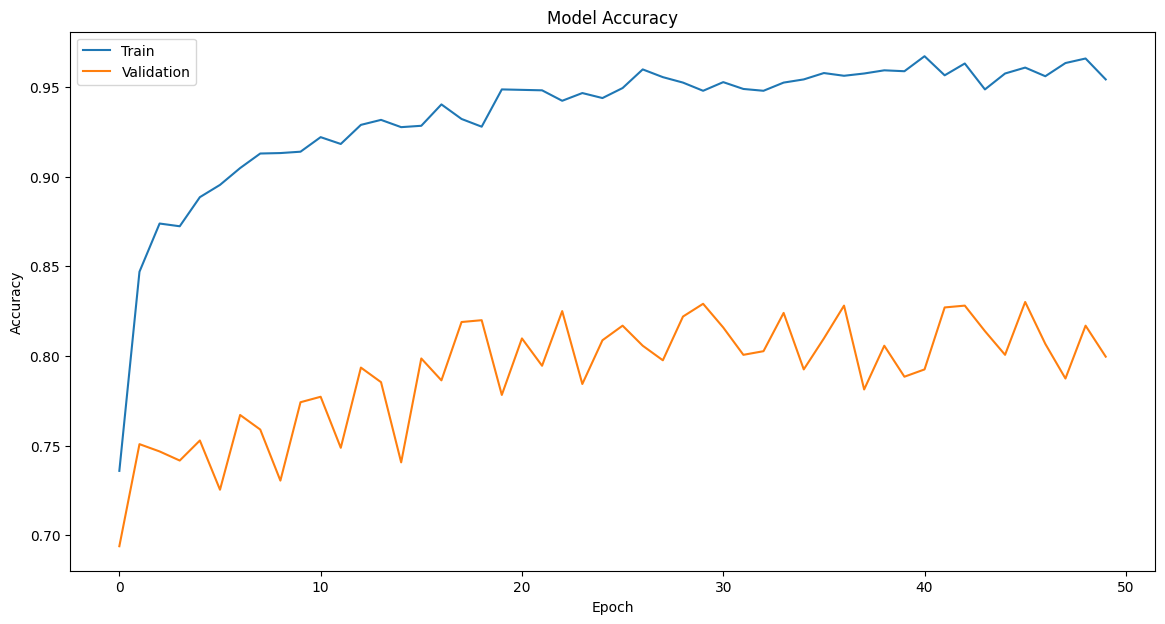

In [17]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot the Training and Validation Loss

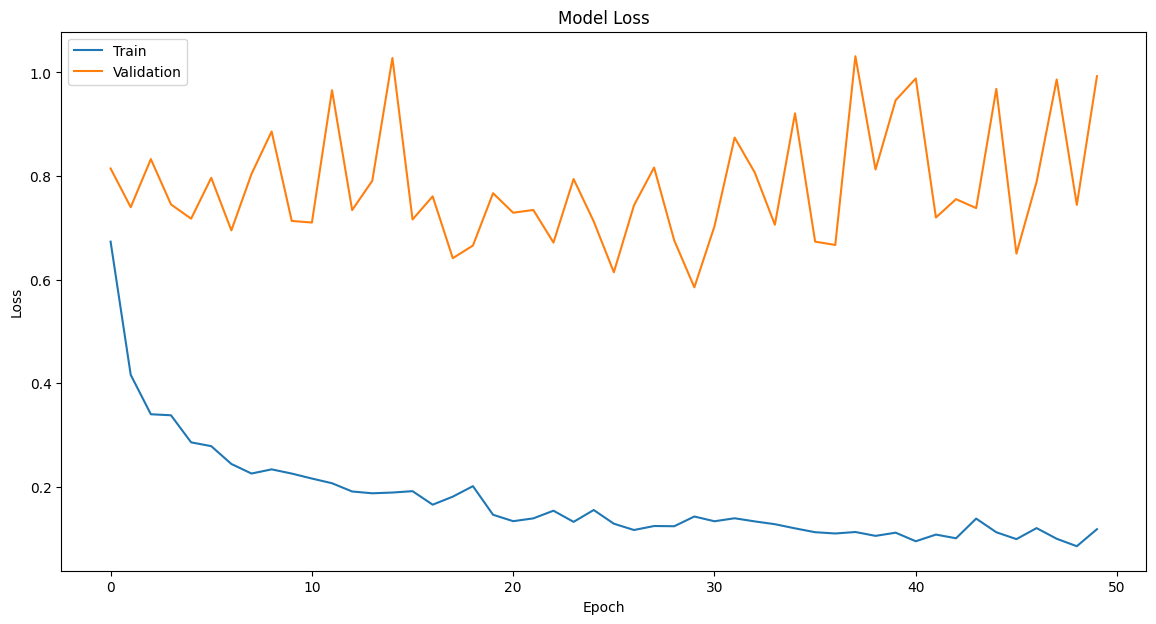

In [18]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test the model on the test data

In [19]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

41/41 [==============================] - 12s 285ms/step - loss: 0.5159 - accuracy: 0.8743
Test accuracy: 0.874316930770874


### Generate predictions on the test data

In [20]:
y_pred = model.predict(test_generator, steps=len(test_generator))
y_true = test_generator.classes

41/41 [==============================] - 12s 265ms/step


### Generate and plot confusion matrix

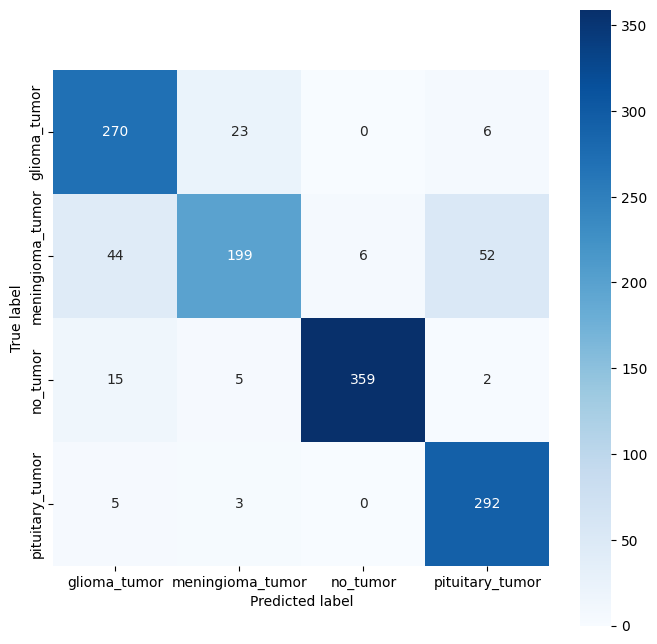

In [21]:
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", square=True, xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Print classification report

In [22]:
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.81      0.90      0.85       299
meningioma_tumor       0.87      0.66      0.75       301
        no_tumor       0.98      0.94      0.96       381
 pituitary_tumor       0.83      0.97      0.90       300

        accuracy                           0.87      1281
       macro avg       0.87      0.87      0.87      1281
    weighted avg       0.88      0.87      0.87      1281



### Compute precision, recall, F1 score and support for each class

In [23]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1))

In [24]:
# Create a dataframe with the computed metrics for each class
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Support': support
}, index=class_names)

# Print the dataframe
print(metrics_df)

                  Precision    Recall  F1 Score  Support
glioma_tumor       0.808383  0.903010  0.853081      299
meningioma_tumor   0.865217  0.661130  0.749529      301
no_tumor           0.983562  0.942257  0.962466      381
pituitary_tumor    0.829545  0.973333  0.895706      300


### Compute ROC and AUC for each class

In [25]:
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC and AUC for each class
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Plot ROC curve for each class

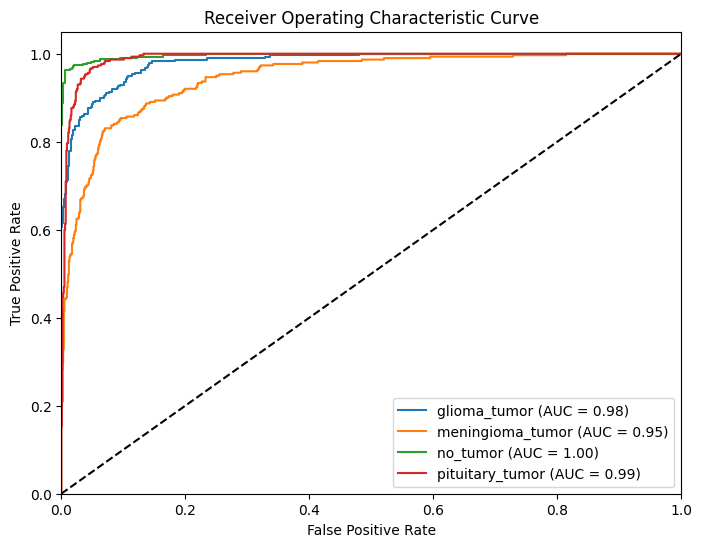

In [26]:
plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label='%s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()